In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")
overlay.load_model("dpu_HatDetection.elf")

In [2]:
import matplotlib.pyplot as plt
import time
import os
import cv2
import colorsys
import random
import numpy as np
from dnndk import n2cube
%matplotlib inline

In [3]:
'''resize image with unchanged aspect ratio using padding'''
def letterbox_image(image, size):
    ih, iw, _ = image.shape
    w, h = size
    scale = min(w/iw, h/ih)
    
    nw = int(iw*scale)
    nh = int(ih*scale)


    image = cv2.resize(image, (nw,nh), interpolation=cv2.INTER_LINEAR)
    new_image = np.ones((h,w,3), np.uint8) * 128
    h_start = (h-nh)//2
    w_start = (w-nw)//2
    new_image[h_start:h_start+nh, w_start:w_start+nw, :] = image
    return new_image

'''image preprocessing'''
def pre_process(image, model_image_size):
    image = image[...,::-1]
    image_h, image_w, _ = image.shape
 
    if model_image_size != (None, None):
        assert model_image_size[0]%32 == 0, 'Multiples of 32 required'
        assert model_image_size[1]%32 == 0, 'Multiples of 32 required'
        boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    else:
        new_image_size = (image_w - (image_w % 32), image_h - (image_h % 32))
        boxed_image = letterbox_image(image, new_image_size)
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) 	
    return image_data

'''Get model classification information'''	
def get_class(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

'''Get model anchors value'''
def get_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)
    
def _get_feats(feats, anchors, num_classes, input_shape):
    num_anchors = len(anchors)
    anchors_tensor = np.reshape(np.array(anchors, dtype=np.float32), [1, 1, 1, num_anchors, 2])
    grid_size = np.shape(feats)[1:3]
    nu = num_classes + 5
    predictions = np.reshape(feats, [-1, grid_size[0], grid_size[1], num_anchors, nu])
    grid_y = np.tile(np.reshape(np.arange(grid_size[0]), [-1, 1, 1, 1]), [1, grid_size[1], 1, 1])
    grid_x = np.tile(np.reshape(np.arange(grid_size[1]), [1, -1, 1, 1]), [grid_size[0], 1, 1, 1])
    grid = np.concatenate([grid_x, grid_y], axis = -1)
    grid = np.array(grid, dtype=np.float32)

    box_xy = (1/(1+np.exp(-predictions[..., :2])) + grid) / np.array(grid_size[::-1], dtype=np.float32)
    box_wh = np.exp(predictions[..., 2:4]) * anchors_tensor / np.array(input_shape[::-1], dtype=np.float32)
    box_confidence = 1/(1+np.exp(-predictions[..., 4:5]))
    box_class_probs = 1/(1+np.exp(-predictions[..., 5:]))
    return box_xy, box_wh, box_confidence, box_class_probs

def correct_boxes(box_xy, box_wh, input_shape, image_shape):
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = np.array(input_shape, dtype = np.float32)
    image_shape = np.array(image_shape, dtype = np.float32)
    new_shape = np.around(image_shape * np.min(input_shape / image_shape))
    offset = (input_shape - new_shape) / 2. / input_shape
    scale = input_shape / new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes = np.concatenate([
        box_mins[..., 0:1],
        box_mins[..., 1:2],
        box_maxes[..., 0:1],
        box_maxes[..., 1:2]
    ], axis = -1)
    boxes *= np.concatenate([image_shape, image_shape], axis = -1)
    return boxes

def boxes_and_scores(feats, anchors, classes_num, input_shape, image_shape):
    box_xy, box_wh, box_confidence, box_class_probs = _get_feats(feats, anchors, classes_num, input_shape)
    boxes = correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = np.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = np.reshape(box_scores, [-1, classes_num])
    return boxes, box_scores	

'''Draw detection frame'''
def draw_bbox(image, bboxes, classes):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """
    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = colors[class_ind]
        bbox_thick = int((image_h + image_w) / 300)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)
    return image

def nms_boxes(boxes, scores):
    """Suppress non-maximal boxes.

    # Arguments
        boxes: ndarray, boxes of objects.
        scores: ndarray, scores of objects.

    # Returns
        keep: ndarray, index of effective boxes.
    """
    nms_thresh=0.4

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2-x1+1)*(y2-y1+1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w1 = np.maximum(0.0, xx2 - xx1 + 1)
        h1 = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w1 * h1

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= nms_thresh)[0]  # threshold
        order = order[inds + 1]

    return keep	
  
'''Model post-processing'''

'Model post-processing'

In [4]:
"""Get model classification information"""
classes_path = "./new_classes.txt"
class_names = get_class(classes_path)

"""Get model anchor value"""
anchors_path = "./yolo_anchors.txt"
anchors = get_anchors(anchors_path)

In [5]:

def eval(yolo_outputs, image_shape, class_names, anchors):
    score_thresh = 0.80
    class_names = get_class(classes_path)
    anchors     = get_anchors(anchors_path)
    anchor_mask = [[3, 4, 5], [1, 2, 3]]
    boxes = []
    box_scores = []
    
    input_shape = np.shape(yolo_outputs[0])[1 : 3]
    input_shape = np.array(input_shape)*32
    
    for i in range(len(yolo_outputs)):
        _boxes, _box_scores = boxes_and_scores(yolo_outputs[i], anchors[anchor_mask[i]], len(class_names), input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = np.concatenate(boxes, axis = 0)
    box_scores = np.concatenate(box_scores, axis = 0)
    
    mask = box_scores >= score_thresh
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(len(class_names)):
        class_boxes_np = boxes[mask[:, c]]
        class_box_scores_np = box_scores[:, c]
        class_box_scores_np = class_box_scores_np[mask[:, c]]
        nms_index_np = nms_boxes(class_boxes_np, class_box_scores_np) 
        class_boxes_np = class_boxes_np[nms_index_np]
        class_box_scores_np = class_box_scores_np[nms_index_np]
        classes_np = np.ones_like(class_box_scores_np, dtype = np.int32) * c
        boxes_.append(class_boxes_np)
        scores_.append(class_box_scores_np)
        classes_.append(classes_np)
    boxes_ = np.concatenate(boxes_, axis = 0)
    scores_ = np.concatenate(scores_, axis = 0)
    classes_ = np.concatenate(classes_, axis = 0)
    
    return boxes_, scores_, classes_

"""DPU Kernel Name for tf_yolov4_tiny"""
KERNEL_CONV="HatDetection"
#libdpumodeltf_yolov3_voc.so
"""DPU IN/OUT Name for tf_yolov4_tiny"""
CONV_INPUT_NODE="conv2d_1_convolution"
CONV_OUTPUT_NODE1="conv2d_21_convolution"
CONV_OUTPUT_NODE2="conv2d_24_convolution"

In [6]:
""" Attach to DPU driver and prepare for running """
n2cube.dpuOpen()

""" Create DPU Kernels for tf_yolov3_voc """
kernel = n2cube.dpuLoadKernel(KERNEL_CONV)

""" Create DPU Tasks for tf_yolov3_voc """
task = n2cube.dpuCreateTask(kernel, 0)

In [7]:
""" Running time calculate (start) """
time_start=time.clock()

"""Load image to DPU"""
image_path = "./000009.jpg"
print("Loading picture from image folder...")
image = cv2.imread(image_path)	
image_ho, image_wo, _ = image.shape
image_size = image.shape[:2]
# image_data = pre_process(image, (416, 416))
# image_data = np.array(image_data,dtype=np.float32)
image_data = np.array(pre_process(image, (416, 416)), dtype=np.float32)
input_len = n2cube.dpuGetInputTensorSize(task, CONV_INPUT_NODE)

#conv_time_start = time.clock() # <------------- Start Convolution Time Recording

"""Get input Tesor"""
n2cube.dpuSetInputTensorInHWCFP32(task,CONV_INPUT_NODE,image_data,input_len)

"""Model run on DPU"""
n2cube.dpuRunTask(task)


conv_sbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE1)
conv_out1 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE1, conv_sbbox_size)
conv_out1 = np.reshape(conv_out1, (1, 13, 13, 18))

conv_mbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE2)
conv_out2 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE2, conv_mbbox_size)
conv_out2 = np.reshape(conv_out2, (1, 26, 26, 18))


#print('Convlution Speed: %s FPS'%(1/(time.clock()-conv_time_start))) # <------------ Convolution Time Printing

yolo_outputs = [conv_out1, conv_out2]    



"""Post-processing"""   
out_boxes, out_scores, out_classes = eval(yolo_outputs, image_size,class_names,anchors)

""" Running time calculate(over) and print """
time_end=time.clock()
run_fps = 1/(time_end-time_start)
print('Running Speed: %s FPS'%(run_fps))

Loading picture from image folder...
Running Speed: 11.074687693806988 FPS


predicted_class: Hat
score: 0.977018
run_fps 11.074687693806988


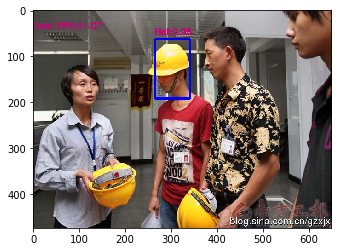

In [8]:
items = []
draws = []
for i, c in reversed(list(enumerate(out_classes))):
    predicted_class = class_names[c] #class LUT
    box = out_boxes[i]
    score = out_scores[i]

    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image_ho, np.floor(bottom + 0.5).astype('int32'))
    right = min(image_wo, np.floor(right + 0.5).astype('int32'))
    draw  = [left, top, right, bottom, score, c]
    item  = [predicted_class, score, left, top, right, bottom]
    draws.append(draw)
    items.append(item)

    texted_image = cv2.putText(image, predicted_class+':'+str(round(score,2)), (left,top-10), cv2.FONT_ITALIC, 0.6, (122, 0, 204), 2)
    texted_image = cv2.putText(texted_image, 'Total FPS'+':'+str(round(run_fps,2)), (0,40), cv2.FONT_ITALIC, 0.6, (122, 0, 204), 2)
    print("predicted_class:",predicted_class)
    print("score:",score)
    print("run_fps",run_fps)
image_result = draw_bbox(texted_image, draws, class_names)
im2 = image_result[:,:,::-1]
plt.imshow(im2)
plt.savefig('test.png')
plt.show()

In [ ]:
n2cube.dpuDestroyTask(task)
n2cube.dpuDestroyKernel(kernel)